Fold 0 started at Sun Dec 26 13:37:13 2021
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
Fold 1 started at Sun Dec 26 13:37:23 2021
Fold 2 started at Sun Dec 26 13:37:33 2021
Fold 3 started at Sun Dec 26 13:37:43 2021
Fold 4 started at Sun Dec 26 13:37:53 2021
COMIENZO DE VALIDACIÓN
CV score: 0.0479.
FIN DE VALIDACIÓN


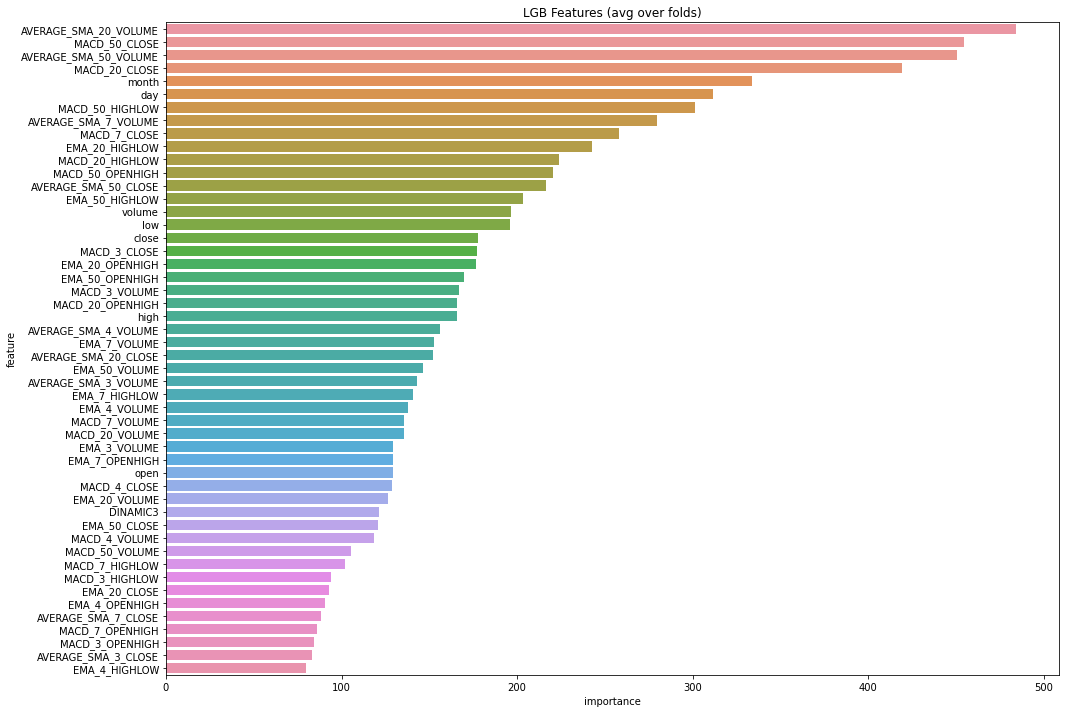

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import time
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
import math

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold, RepeatedStratifiedKFold, cross_validate, StratifiedShuffleSplit
from sklearn import metrics

# DATA LOADING
from sklearn.neural_network import MLPClassifier

path = '/kaggle/input/stock-market-prediction/'
pathOutput = './'
completoTrain='dataset_train_validation.csv'
completoTest='dataset_test.csv'

# INPUT
train = pd.read_csv(os.path.join(path, completoTrain))
test = pd.read_csv(os.path.join(path, completoTest))

# Se separan los resultados reales con los que comparar
columns =  [col for col in test.columns if col not in ['company', 'age', 'market', 'TARGET']]
submission = test[columns]
solucion = test['TARGET']

####################### ELIMINACION de filas con null en la columna TARGET
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

train = filter_rows_by_values(train, "TARGET", ["null"])

########################## NUEVAS FEATURES ###########################
######33###### RSI ###################
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

################################# NUEVAS FEATURES TRAIN
train['close_lag'] = train['close'].shift(1)
train['RSI'] = relative_strength_idx(train).fillna(0)
train = train.fillna(0)

################################## NUEVAS FEATURES TEST
# all the same for the test data
test['close_lag'] = test['close'].shift(1)
test['RSI'] = relative_strength_idx(test).fillna(0)
test = test.fillna(0)

#########################################
# Se fraccionan los datos de train en: train + validación
fraccion_train = 0.7  # Fracción de datos usada para entrenar
fraccion_valid = 1.00 - fraccion_train
train_aleatorio = train.sample(frac=1)
train = train_aleatorio.iloc[:int(fraccion_train * len(train)), :]
validacion = train_aleatorio.iloc[int(fraccion_train * len(train)):, :]

################# Se separa en features y target
train_X = train[columns]
train_y = train['TARGET']
valid_X = validacion[columns]
valid_y = validacion['TARGET']

# MODEL TRAINING
###################### MODELO LGBM ######################
folds = GroupKFold(n_splits=5)
params = {'objective': 'binary',
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "metric": 'precision',
          'n_jobs': -1,
          'min_data_in_leaf': 32,
          'num_leaves': 1024,
          }
for fold_n, (train_index, valid_index) in enumerate(folds.split(train_X, train_y, groups=train['company'])):
    print(f'Fold {fold_n} started at {time.ctime()}')
    X_train, X_valid = train_X[columns].iloc[train_index], train_X[columns].iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    model = lgb.LGBMClassifier(**params, n_estimators=50)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)])
#####################################################

#################### SE DIBUJAN LAS FEATURES POR IMPORTANCIA #################
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
fold_importance["feature"] = columns
fold_importance["importance"] = model.feature_importances_
fold_importance["fold"] = fold_n + 1
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

feature_importance["importance"] /= 5
# Se pintan las primeras 50 features
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGB Features (avg over folds)');
# plt.show(block=False)
# plt.pause(5)
plt.savefig(pathOutput + "BOLSA_feature_importances.png")
# plt.close()
###################

##################### VALIDACIÓN ###################
print("COMIENZO DE VALIDACIÓN")
score = metrics.mean_absolute_error(valid_y, model.predict(valid_X))
print('CV score: {0:.4f}.'.format(score))
print("FIN DE VALIDACIÓN")
###############################################




# **Independent prediction:**



In [2]:
# PREDICCIÓN independiente

# Eliminación de filas a null
test = filter_rows_by_values(test, "TARGET", ["null"])

submission = test[columns]
solucion = test['TARGET']

# Sólo aplicable si hay sigmoid en la última capa
prediccion = (model.predict(submission) > 0.5).astype("int32")
submission['TARGET']=prediccion

# Se añade la empresa en la primera columna y se guarda en Excel
submission=submission.join(test['company'])
submission.set_index(submission.pop('company'), inplace=True)
submission.reset_index(inplace=True)
submission.to_csv(os.path.join(pathOutput, 'Bolsa_DL_submission.csv'), index=False)

# PRECISION independiente
a=solucion
b=prediccion
TP=sum(1 for x,y in zip(a,b) if (x == y and y == 1))
TPandFP=sum(b)
precision= TP / TPandFP
print("TP: ", TP)
print("TP + FP: ", TPandFP)
print("---->>>>>> PRECISION (TP/(TP+FP)) FOR TEST DATASET: {0:.2f}% <<<<<<------".format(precision * 100))

# Tasa de desbalanceo
ift_mayoritaria = test[test.TARGET == False]
ift_minoritaria = test[test.TARGET == True]
tasaDesbalanceo = round(ift_mayoritaria.shape[0] / ift_minoritaria.shape[0], 2)
print("Tasa de desbalanceo = " + str(ift_mayoritaria.shape[0]) + "/" + str(
        ift_minoritaria.shape[0]) + " = " + str(tasaDesbalanceo))

print("Tasa de mejora de precisión respecto a random: ",
              round(precision / (1/(1+tasaDesbalanceo)), 2))

from sklearn.metrics import classification_report
print("Informe de metricas:")
print(classification_report(a, b))

print("END")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


TP:  51
TP + FP:  123
---->>>>>> PRECISION (TP/(TP+FP)) FOR TEST DATASET: 41.46% <<<<<<------
Tasa de desbalanceo = 93534/4658 = 20.08
Tasa de mejora de precisión respecto a random:  8.74
Informe de metricas:
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98     93534
         1.0       0.41      0.01      0.02      4658

    accuracy                           0.95     98192
   macro avg       0.68      0.51      0.50     98192
weighted avg       0.93      0.95      0.93     98192

END
